In [66]:
from lib import Estimator, load_dataset
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import random

In [3]:
X_val, y_val, X_test, y_test = load_dataset("../dataset", rgb=False)

In [4]:
X_val_bgr = X_val

In [5]:
def show_image(img, to_rgb=True):
    if to_rgb:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        rgb = img
    plt.imshow(rgb,interpolation='nearest')
    plt.show()

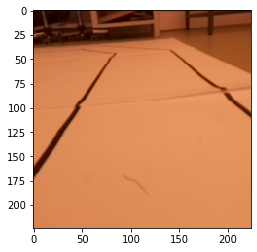

In [6]:
show_image(X_val_bgr[200])

In [7]:
class Config:
    def __init__(self, *args, **kwargs):
        self._d = kwargs
    def __getattr__(self, name):
        return self._d[name]

In [8]:
config = Config(
    gaussian_blur_kernel_size=(3, 3),
    gaussian_blur_sigma_x=1,
    top_offset_pct=0.3,
    canny_threshold1=100,
    canny_threshold2=200,
    houghlines_rho=1,
    houghlines_theta=np.pi/180,
    houghlines_threshold=50,
)

In [9]:
def get_line_color_code(rho, theta):
    b, g, r = 0, 0, 0
    # towards left: red
    if theta > np.pi/2:
        r = 255
    # towards right: blue
    else:
        b = 255
    # negative rho: add green
    if rho < 0:
        g = 100
    return b, g, r

In [47]:
from math import isclose

def get_lines(img, show=False):
    if show:
        show_image(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show:
        show_image(gray)
        
    blur = cv2.GaussianBlur(gray, config.gaussian_blur_kernel_size, config.gaussian_blur_sigma_x)
    if show:
        show_image(blur)

    height, width = blur.shape
#     mask = np.zeros((height, width, 1), np.uint8)
#     mask[int(height * 0.3):height,:] = 1 # (B, G, R)
#     blur_bottom = cv2.bitwise_and(blur, blur, mask=mask)
    offset = int(height * config.top_offset_pct)
    blur_bottom = blur[offset:height,:]
    if show:
        show_image(blur_bottom)
    
    edges = cv2.Canny(blur_bottom, config.canny_threshold1, config.canny_threshold2)
#     edges = cv2.Laplacian(blur_bottom, cv2.CV_8U)
    if show:
        show_image(edges)
    
    lines = cv2.HoughLines(edges, config.houghlines_rho, config.houghlines_theta, config.houghlines_threshold)
    img_lines = img.copy()

    if lines is None:
        return None, None
    
    for line in lines:
        for rho, theta in line:
#             if isclose(theta, np.pi/2, rel_tol = 1e-05):
#                 continue
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img_lines, (x1, y1+offset), (x2, y2+offset), get_line_color_code(rho, theta), 2)
    if show:
        show_image(img_lines)
            
    return lines, img_lines
    

In [11]:
begin = time.time()
get_lines(X_val_bgr[200])
end = time.time()
print(f"get_lines took {end-begin:.3}s")

get_lines took 0.00288s


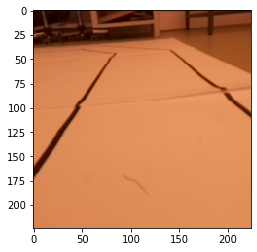

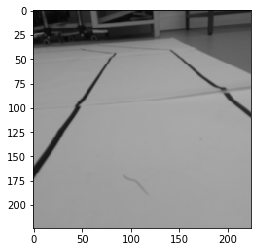

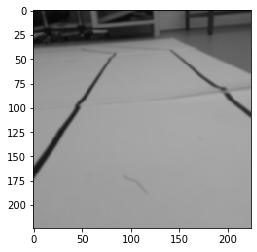

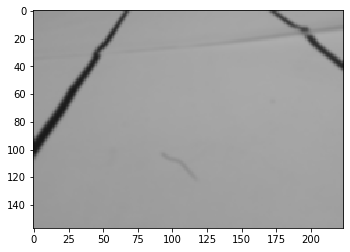

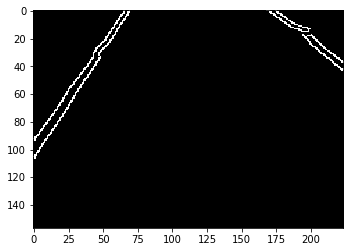

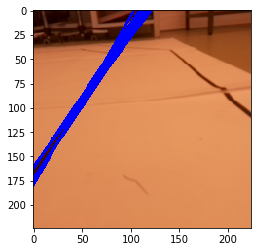

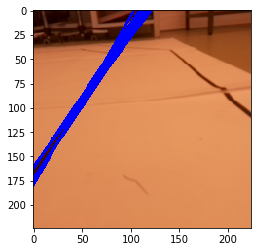

In [12]:
show_image(get_lines(X_val_bgr[200], show=True)[1])

In [13]:
img_set = [X_val_bgr[i] for i in range(0, 4000, 150)]

In [14]:
img_lines_set = [get_lines(img)[1] for img in img_set]

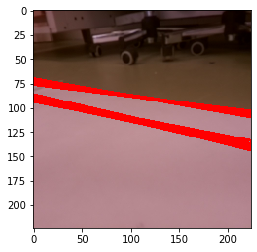

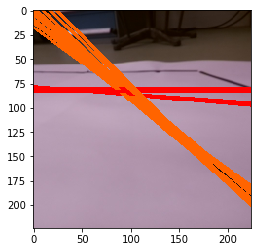

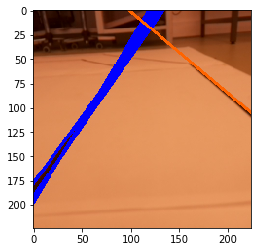

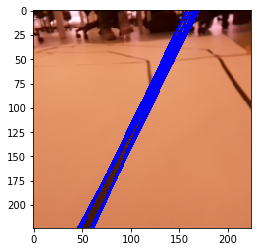

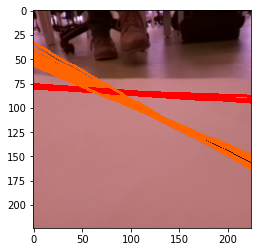

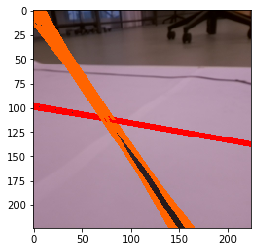

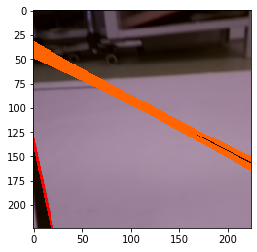

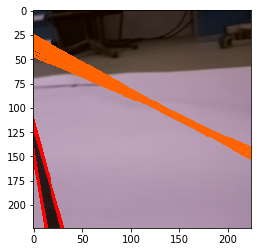

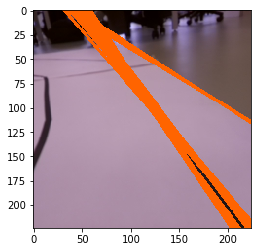

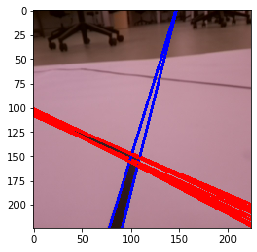

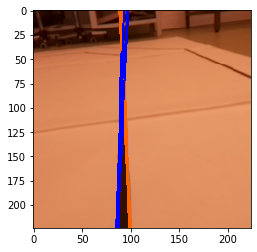

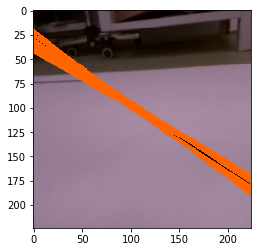

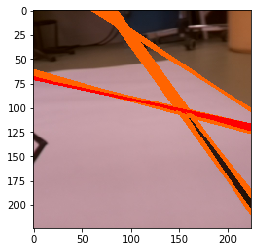

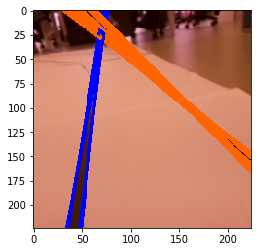

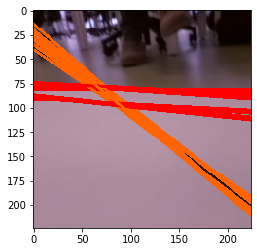

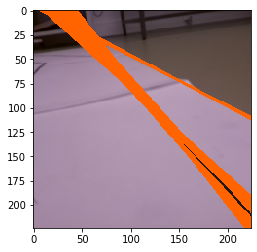

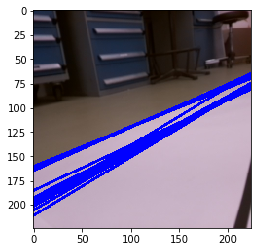

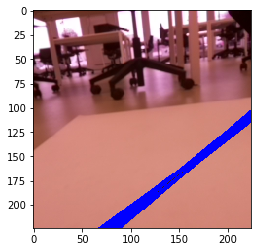

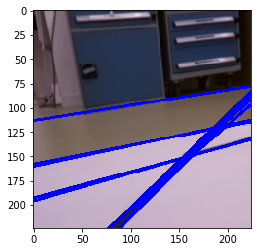

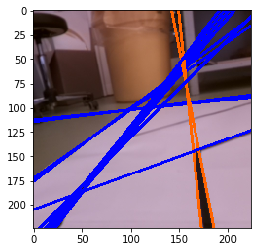

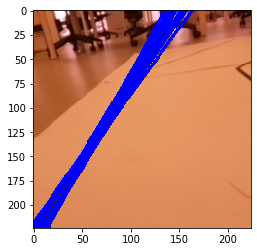

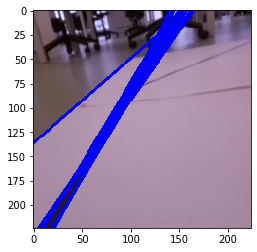

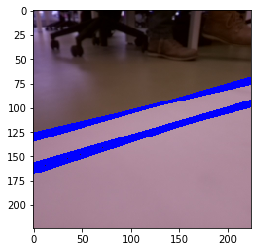

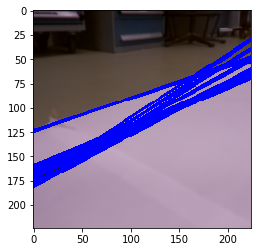

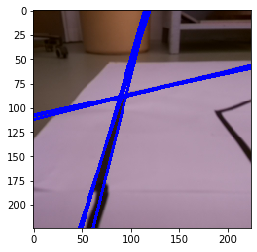

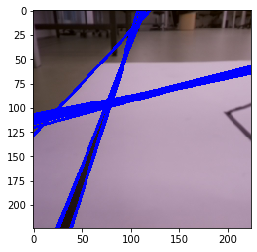

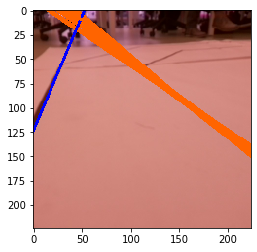

In [15]:
for img_lines in img_lines_set:
    show_image(img_lines)

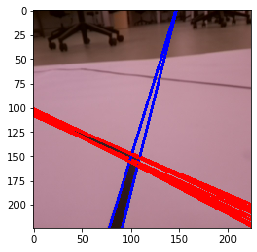

In [16]:
lines, img_lines = get_lines(X_val_bgr[1350])
show_image(img_lines)

In [17]:
for line in lines:
    for rho, theta in line:
        print(rho, theta)

33.0 1.9896753
37.0 2.0071287
34.0 1.9722221
36.0 2.024582
126.0 0.2443461
38.0 1.9896753
34.0 2.042035
120.0 0.29670596
31.0 2.0071287
32.0 2.0594885


In [103]:
def get_direction(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction and intensity from difference (-pi/2 to pi/2)
    if not left and not right:
        return 0
    elif not left:
        diff = - np.mean(right)
    elif not right:
        diff = np.mean(left)
    else:
        diff = np.mean(left) - np.mean(right)
    # normalize
    return -diff/(np.pi/2)

In [104]:
get_direction(lines)

-0.5472222355511159

In [105]:
class ClassicHoughlinesEstimator(Estimator):
    def __init__(self, get_lines, get_direction):
        self.get_lines = get_lines
        self.get_direction = get_direction
    
    def predict_one(self, img):
        return self.get_direction(self.get_lines(img)[0])

In [106]:
ClassicHoughlinesEstimator(get_lines, get_direction).score(X_test, y_test)

(0.26153760758487754, 0.4002033404892157)

In [60]:
def get_direction_threshold(threshold):
    def get_direction(lines):
        if lines is None:
            return 0
        left = []
        right = []
        for line in lines:
            for rho, theta in line:
                # the higher the value, the more we should turn
                if theta > np.pi/2:
                    left.append(np.pi - theta)
                else:
                    right.append(theta)
        # get direction from difference
        if not left and not right:
            return 0
        elif not left:
            direction = right
        elif not right:
            direction = left
        else:
            diff = np.mean(left) - np.mean(right)
            if (abs(diff) < threshold):
                return 0
            direction = left if diff > 0 else right
        # keep intensity from main direction
        intensity = np.mean(direction)
        # normalize
        if direction == left:
            return -intensity/(np.pi/2)
        return intensity/(np.pi/2)
    return get_direction

In [63]:
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7]:
    print(ClassicHoughlinesEstimator(get_lines, get_direction_threshold(threshold)).score(X_test, y_test))

(0.4138145883247093, 0.5045993904818162)
(0.38404148437591723, 0.47753921427612994)
(0.3190757782908618, 0.43634362865739523)
(0.22689192338285383, 0.3896400602729451)
(0.2151509157487499, 0.3804850865623736)
(0.21539769491189642, 0.37984037312593727)
(0.21539769491189642, 0.37984037312593727)
(0.21539769491189642, 0.37984037312593727)
(0.21539769491189642, 0.37984037312593727)


In [64]:
class ZeroEstimator(Estimator):
    def predict_one(self, img):
        return 0

In [65]:
print(ZeroEstimator().score(X_test, y_test))

(0.6215464813205908, 0.6893136403127715)


In [85]:
class DumbEstimator(Estimator):
    def predict_one(self, img):
        return 2*random.random()-1

In [86]:
print(DumbEstimator().score(X_test, y_test))

(0.9474005861348597, 0.8040345091711997)


In [130]:
def get_direction_max(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return np.max(right)/(np.pi/2)
    elif not right:
        return -np.max(left)/(np.pi/2)
    else:
        return 0

In [131]:
ClassicHoughlinesEstimator(get_lines, get_direction_max).score(X_test, y_test)

(0.20524975167577542, 0.34360458385762627)

In [132]:
def stick_to_labels(get_direction):
    def f(lines):
        if get_direction(lines) < -0.75:
            return -1
        elif get_direction(lines) < -0.25:
            return -0.5
        elif get_direction(lines) < 0.25:
            return 0
        elif get_direction(lines) < 0.75:
            return 0.5
        return 1
    return f

In [133]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_max)).score(X_test, y_test)

(0.21072980017376194, 0.29582971329278895)

In [134]:
def get_direction_sin_max(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return math.sin(np.max(right))
    elif not right:
        return math.sin(-np.max(left))
    else:
        return 0

In [135]:
ClassicHoughlinesEstimator(get_lines, get_direction_sin_max).score(X_test, y_test)

(0.1977056342726155, 0.28817322665523026)

In [136]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_sin_max)).score(X_test, y_test)

(0.19778453518679406, 0.2668114682884449)

In [140]:
def get_direction_sin_mean(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return math.sin(np.mean(right))
    elif not right:
        return math.sin(-np.mean(left))
    else:
        return 0

In [141]:
ClassicHoughlinesEstimator(get_lines, get_direction_sin_mean).score(X_test, y_test)

(0.19426700103208064, 0.30838609942867357)

In [142]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_sin_mean)).score(X_test, y_test)

(0.1923110338835795, 0.269244135534318)